In [2]:
import joblib
import numpy as np
import datetime
import pandas as pd

# load the saved model 
model = joblib.load("./Data/hvac_energy_model.pkl")

In [3]:
import datetime 

def hvac_control(
    air_temp: float,
    
    dew_temp: float,
    cloud_coverage: float,
    precip_depth: float,
    sea_level_pressure: float,
    wind_direction: float,
    wind_speed: float,
    primary_use: str,
    square_feet: float,
    year_built: int,
    floor_count: int,
    timestamp: datetime.datetime,
    occupancy: bool):

    # create timestamps
    hour = timestamp.hour
    weekday = timestamp.weekday()

    primary_use_mapping = { 
        'Education': 0, 'Office': 1, 'Lodging/residential': 2, 
        'Entertainment/public assembly': 3, 'Public services': 4,
        'Healthcare': 5, 'Warehouse/storage': 6, 'Manufacturing/industrial': 7,
        'Retail': 8, 'Food sales and service': 9, 'Parking': 10,
        'Technology/science': 11, 'Utility': 12, 'Religious worship': 13,
        'Other': 14
    }
    
    primary_use = primary_use_mapping.get(primary_use, -1)

    if primary_use == -1:
        return("Unkown primary use type.")

    log_sqft = np.log1p(square_feet)

    input_features = pd.DataFrame([{
    'air_temperature': air_temp,
    'dew_temperature': dew_temp,
    'cloud_coverage': cloud_coverage,
    'precip_depth_1_hr': precip_depth,
    'sea_level_pressure': sea_level_pressure,
    'wind_direction': wind_direction,
    'wind_speed': wind_speed,
    'primary_use': primary_use,
    'log_square_feet': log_sqft,
    'year_built': year_built,
    'floor_count': floor_count,
    'hour': hour,
    'weekday': weekday
    }])

    predicted_usage = model.predict(input_features)[0]
    # print(predicted_usage)

    if primary_use in [0, 5]:  # Education, Healthcare
        heating_threshold = 21
        cooling_threshold = 23
    else:
        heating_threshold = 20
        cooling_threshold = 24
    
    # if not occupancy:
    #     decision = "HVAC Off, Unoccupied"
    # elif air_temp < heating_threshold and predicted_usage < 10:
    #     decision = "Heating on"
    # elif air_temp > cooling_threshold and predicted_usage > 15:
    #     decision = "Cooling on"
    # else:
    #     decision = "Maintain"

    # if not occupancy:
    #     decision = "HVAC Off, Unoccupied"
    # elif air_temp < heating_threshold and predicted_usage < 20:
    #     decision = "Heating on"
    # elif air_temp > cooling_threshold and predicted_usage > 30:
    #     decision = "Cooling on"
    # else:
    #     decision = "Maintain"

    if not occupancy:
        decision = "HVAC Off, Unoccupied"

    elif air_temp < heating_threshold and predicted_usage < 25:
        decision = "Heating on"

    elif air_temp > cooling_threshold and predicted_usage > 25:
        decision = "Cooling on"

    else:
        decision = "Maintain"

    print(f"[{timestamp}] Predicted: {predicted_usage:.2f} → Action: {decision}, Occupancy: {occupancy}")

    return decision

In [5]:
import numpy as np
import pandas as pd
from datetime import datetime

def get_random_occupancy(hour: int) -> bool:
    if 8 <= hour <= 18:
        return np.random.rand() < 0.9
    else:
        return np.random.rand() < 0.1

# def get_random_occupancy(hour: int) -> bool:
#     if 8 <= hour <= 18:
#         return np.random.rand() < 1
#     else:
#         return np.random.rand() < 1
        
def simulate_hvac_day(
    site_id: int,
    date: str,
    primary_use: str,
    square_feet: float,
    year_built: int,
    floor_count: int,
    weather_df: pd.DataFrame
) -> pd.DataFrame:
    
    date_filter = (weather_df['site_id'] == site_id) & (weather_df['timestamp'].dt.date == pd.to_datetime(date).date())
    day_weather = weather_df[date_filter].sort_values('timestamp')

    results = []

    for _, row in day_weather.iterrows():
        ts = row['timestamp']
        hour = ts.hour

        air_temp = row.get('air_temperature', np.nan)
        print(f'Hour: {hour}, temp:{air_temp}')
        dew_temp = row.get('dew_temperature', np.nan)
        cloud_coverage = row.get('cloud_coverage', 0)
        precip_depth = row.get('precip_depth_1_hr', 0)
        sea_level_pressure = row.get('sea_level_pressure', 1013)
        wind_direction = row.get('wind_direction', 180)
        wind_speed = row.get('wind_speed', 2)

        occupied = get_random_occupancy(hour)

        if pd.isna(air_temp) or pd.isna(dew_temp):
            continue

        decision = hvac_control(
            air_temp, dew_temp, cloud_coverage, precip_depth, sea_level_pressure,
            wind_direction, wind_speed, primary_use, square_feet,
            year_built, floor_count, ts, occupied
        )

        results.append({
            'timestamp': ts,
            'air_temperature': air_temp,
            'dew_temperature': dew_temp,
            'cloud_coverage': cloud_coverage,
            'wind_speed': wind_speed,
            'occupancy': occupied,
            'decision': decision
        })

    return pd.DataFrame(results)

Hour: 0, temp:15.0
[2016-03-08 00:00:00] Predicted: 24.73 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 1, temp:14.4
[2016-03-08 01:00:00] Predicted: 24.55 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 2, temp:14.4
[2016-03-08 02:00:00] Predicted: 24.31 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 3, temp:13.3
[2016-03-08 03:00:00] Predicted: 24.79 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 4, temp:13.9
[2016-03-08 04:00:00] Predicted: 24.34 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 5, temp:13.9
[2016-03-08 05:00:00] Predicted: 24.52 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 6, temp:12.8
[2016-03-08 06:00:00] Predicted: 25.01 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 7, temp:13.3
[2016-03-08 07:00:00] Predicted: 30.20 → Action: HVAC Off, Unoccupied, Occupancy: False
Hour: 8, temp:13.3
[2016-03-08 08:00:00] Predicted: 36.80 → Action: Maintain, Occupancy: True
Hour: 9, temp:13.9
[2016-03-08 09:00:00] Predicted

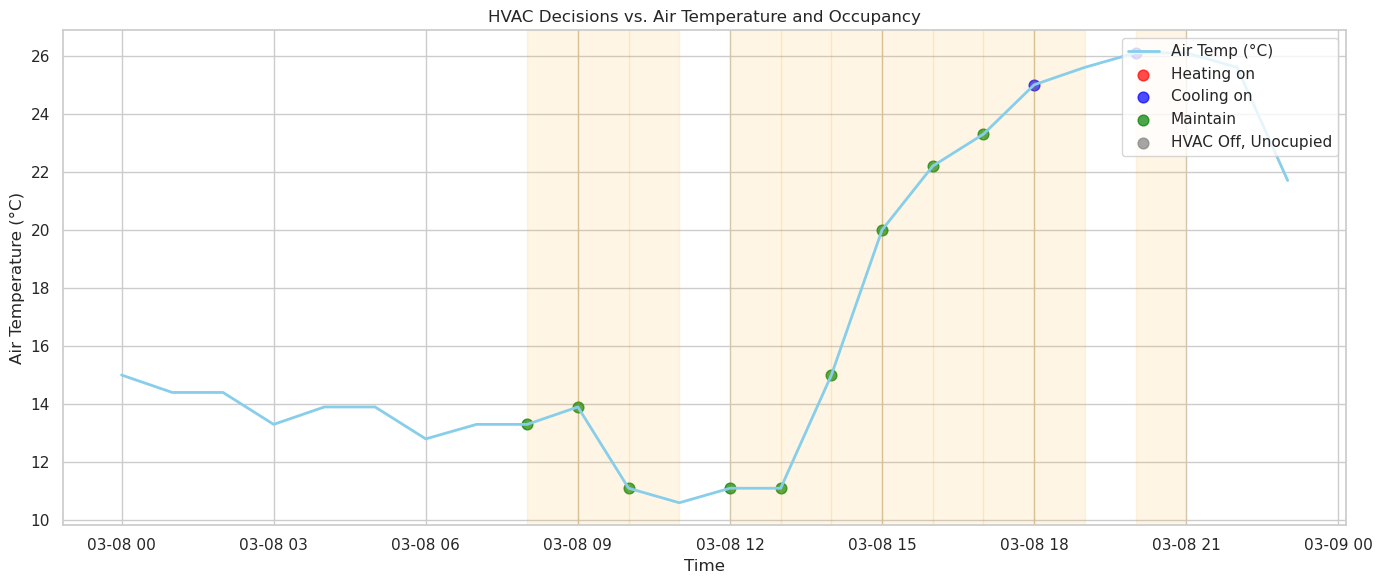

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

weather_df = pd.read_csv("./Data/weather_train.csv")
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])

results_df = simulate_hvac_day(
    site_id=6,
    date='2016-3-8',
    primary_use='Office',
    square_feet=30000,
    year_built=2005,
    floor_count=3,
    weather_df=weather_df
)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

results_df = results_df.sort_values('timestamp')

plt.plot(results_df['timestamp'], results_df['air_temperature'], label='Air Temp (°C)', color='skyblue', linewidth=2)

color_map = {
    "Heating on": "red",
    "Cooling on": "blue",
    "Maintain": "green",
    "HVAC Off, Unocupied": "gray"
}

for decision, color in color_map.items():
    mask = results_df['decision'] == decision
    plt.scatter(
        results_df.loc[mask, 'timestamp'],
        results_df.loc[mask, 'air_temperature'],
        color=color,
        label=decision,
        s=60,
        alpha=0.7
    )

# highlight occupancy
for i, row in results_df.iterrows():
    if row['occupancy']:
        plt.axvspan(row['timestamp'], row['timestamp'] + pd.Timedelta(hours=1), color='orange', alpha=0.1)

# Final touches
plt.title("HVAC Decisions vs. Air Temperature and Occupancy")
plt.xlabel("Time")
plt.ylabel("Air Temperature (°C)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
